In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

charger les donnees


In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
# Vérifier les premières lignes
print(train_data.head())
print(test_data.head())


   id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0   1         M       11.840         18.70           77.93      440.6   
1   2         B       12.760         18.84           81.87      496.6   
2   3         M       23.290         26.67          158.90     1685.0   
3   4         B       12.560         19.07           81.92      485.8   
4   5         B        9.742         15.67           61.50      289.9   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11090           0.15160         0.12180              0.05182   
1          0.09676           0.07952         0.02688              0.01781   
2          0.11410           0.20840         0.35230              0.16200   
3          0.08760           0.10380         0.10300              0.04391   
4          0.09037           0.04689         0.01103              0.01407   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         16.82          

In [6]:
# Information sur les données
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       400 non-null    int64  
 1   diagnosis                400 non-null    object 
 2   radius_mean              400 non-null    float64
 3   texture_mean             400 non-null    float64
 4   perimeter_mean           400 non-null    float64
 5   area_mean                400 non-null    float64
 6   smoothness_mean          400 non-null    float64
 7   compactness_mean         400 non-null    float64
 8   concavity_mean           400 non-null    float64
 9   concave points_mean      400 non-null    float64
 10  symmetry_mean            400 non-null    float64
 11  fractal_dimension_mean   400 non-null    float64
 12  radius_se                400 non-null    float64
 13  texture_se               400 non-null    float64
 14  perimeter_se             4

In [7]:
# Encoder le diagnostic
train_data['diagnosis'] = train_data['diagnosis'].map({'M': 1, 'B': 0})

# Supprimer les colonnes inutiles
X = train_data.drop(columns=['diagnosis', 'id'])
y = train_data['diagnosis']

print(X.head())
print(y.head())

   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0       11.840         18.70           77.93      440.6          0.11090   
1       12.760         18.84           81.87      496.6          0.09676   
2       23.290         26.67          158.90     1685.0          0.11410   
3       12.560         19.07           81.92      485.8          0.08760   
4        9.742         15.67           61.50      289.9          0.09037   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           0.15160         0.12180              0.05182         0.2301   
1           0.07952         0.02688              0.01781         0.1759   
2           0.20840         0.35230              0.16200         0.2200   
3           0.10380         0.10300              0.04391         0.1533   
4           0.04689         0.01103              0.01407         0.2081   

   fractal_dimension_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0           

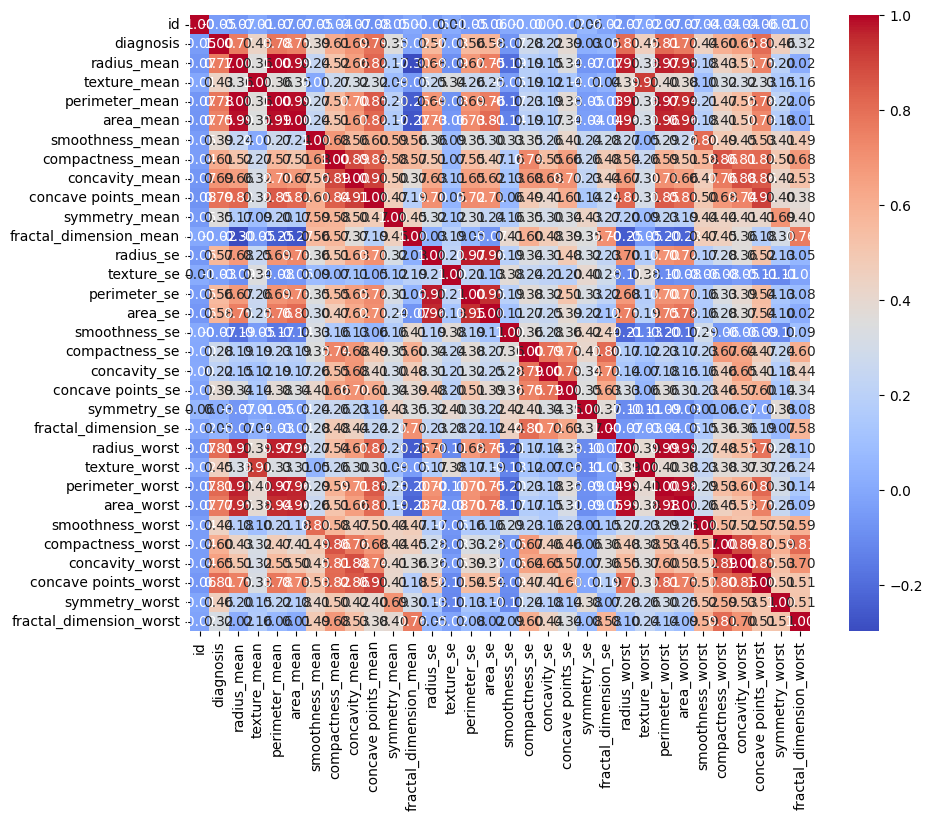

In [8]:
# Visualisation des corrélations
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Separation des donnees pour validation

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Initialiser et entraîner un modèle RandomForest de base
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prédire sur l'ensemble de validation
y_val_pred = model.predict(X_val)

# Évaluer la performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy de base: {accuracy:.2f}')


Accuracy de base: 0.96


In [11]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Meilleurs hyperparamètres: {best_params}')

# Réentraîner le modèle avec les meilleurs hyperparamètres
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

# Recalculer l'accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy après optimisation: {accuracy:.2f}')


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs hyperparamètres: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy après optimisation: 0.97


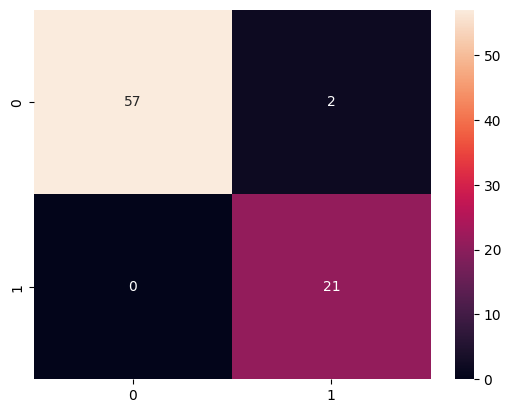

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        59
           1       0.91      1.00      0.95        21

    accuracy                           0.97        80
   macro avg       0.96      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80



In [12]:
# Matrice de confusion et rapport de classification
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

print(classification_report(y_val, y_val_pred))


In [19]:
# Faire des prédictions sur les données test
X_test = test_data.drop(columns=['id'])
test_predictions = best_model.predict(X_test)

# Exporter les résultats
output = pd.DataFrame({'Id': test_data['id'], 'Prediction': test_predictions})
output.to_csv('predictions.csv', index=False)
print("Prédictions exportées avec succès.")


PermissionError: [Errno 13] Permission denied: 'predictions.csv'